In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import wandb
import os, sys
import glob
import numpy as np
import torch
import pandas as pd
import random
import torch.nn as nn
import pickle
import torch.nn.functional as F

In [3]:
from model import C2F_TCN
from dataset import AugmentDataset, collate_fn_override
from utils import calculate_mof, dotdict

In [4]:
os.environ["WANDB_API_KEY"] = "992b3b1371ba79f48484cfca522b3786d7fa52c2"
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dipika_singhania (use `wandb login --relogin` to force relogin)


True

In [5]:
seed = 42

# Ensure deterministic behavior
def set_seed():
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
set_seed()

# Device configuration
os.environ['CUDA_VISIBLE_DEVICES']='6'
# os.environ['CUDA_LAUNCH_BLOCKING']='6'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
config = dotdict(
    epochs=500,
    num_class=48,
    batch_size=50,
    learning_rate=1e-4,
    weight_decay=3e-3,
    dataset="Breakfast",
    architecture="unet-ensemble",
    features_file_name="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/features/",
    chunk_size=10,
    max_frames_per_video=1200,
    feature_size=2048,
    ground_truth_files_dir="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/groundTruth/",
    label_id_csv="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/mapping.csv",
    gamma=0.1,
    step_size=500,
    split=2,
#     output_dir="/mnt/data/ar-datasets/dipika/breakfast/ms_tcn/data/breakfast/results/unsuper-finetune-split2-0.05-data-llr/",
    output_dir="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-maximize/",
    project_name="breakfast-split-2",
    train_split_file="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/train.split{}.bundle",
    test_split_file="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/test.split{}.bundle",
    all_files="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/all_files.txt",
    cutoff=8,
    data_per = 0.2,
    budget=40,
    semi_supervised_split="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/semi_supervised/train.split{}_amt{}.bundle")

config.train_split_file = config.train_split_file.format(config.split)
config.semi_supervised_split = config.semi_supervised_split.format(config.split, config.data_per)
config.test_split_file = config.test_split_file.format(config.split)

if not os.path.exists(config.output_dir):
    os.mkdir(config.output_dir)

print(config)

{'epochs': 500, 'num_class': 48, 'batch_size': 50, 'learning_rate': 0.0001, 'weight_decay': 0.003, 'dataset': 'Breakfast', 'architecture': 'unet-ensemble', 'features_file_name': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/features/', 'chunk_size': 10, 'max_frames_per_video': 1200, 'feature_size': 2048, 'ground_truth_files_dir': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/groundTruth/', 'label_id_csv': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/mapping.csv', 'gamma': 0.1, 'step_size': 500, 'split': 2, 'output_dir': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-maximize/', 'project_name': 'breakfast-split-2', 'train_split_file': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/train.split2.bundle', 'test_split_file': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/test.split2.bundle', 'all_files': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/all_files.txt', 'cutoff': 8, 'data_per': 0.2, 'budget': 40, 'semi_supervised_split': '/mnt/

In [7]:
traindataset = AugmentDataset(config, fold='train', fold_file_name=config.semi_supervised_split, augment=False)

Number of videos logged in train fold is 257
Number of videos not found in train fold is 0


In [8]:
def _init_fn(worker_id):
    np.random.seed(int(seed))
trainloader = torch.utils.data.DataLoader(dataset=traindataset,
                                          batch_size=config.batch_size, 
                                          shuffle=True,
                                          pin_memory=True, num_workers=7, collate_fn=collate_fn_override,
                                          worker_init_fn=_init_fn)

In [9]:
# item = iter(trainloader).next()
# print(item[0]) # -- data feature
# print(item[1]) # -- valid count
# item[2] # -- Actual labels
# print(item[5]) # video names
# video_id_boundary_frames

In [10]:
loaded_vidid_selected_frames = pickle.load(open("dump_dir/loaded_vidid_selected_frames_dict.pkl", "rb"))
# loaded_vidid_selected_frames

In [11]:
video_id_boundary_frames = pickle.load(open("dump_dir/video_id_boundary_frames_dict.pkl", "rb"))
# video_id_boundary_frames

In [12]:
prob_video_each_segment_dict = {}

In [13]:
def prob_vals_per_segment(selected_frames, cur_vid_feat, labels):
    prob_each_segment = []
    
    log_probs = torch.log(cur_vid_feat + 1e-8)
    cumsum_feat = torch.cumsum(log_probs, dim=0)
        
    for i, cur_ele in enumerate(selected_frames[:-1]):
        
        next_ele = selected_frames[i + 1]
        label_cur_ele = labels[cur_ele]
        label_next_ele = labels[next_ele]
        prob_list = []
        for ele in range(cur_ele, next_ele, 1):
            start_sum = cumsum_feat[cur_ele - 1, :] if cur_ele > 0 else 0
            sum_window_class_1 = (cumsum_feat[ele, :] - start_sum)[label_cur_ele]
            sum_window_class_2 = (cumsum_feat[next_ele - 1, :] - cumsum_feat[ele, :])[label_next_ele]
            prob_list.append((sum_window_class_1 + sum_window_class_2))
            
        prob_list = torch.softmax(torch.stack(prob_list), dim=0)
        prob_each_segment.append(prob_list)
    
    return prob_each_segment

In [14]:
# selected_frames = torch.tensor([2, 10, 17, 21])
# cur_vid_feat = torch.randn((27, 48))
# labels = torch.tensor([47, 47, 47, 47, 47, 4, 4, 4, 4, 4, 4, 4, 8, 8, 8, 8, 8, 8, 8, 8, 10, 10, 10, 10, 10, 10, 10])
# # print(len(labels))
# probs_all_segs = prob_vals_per_segment(selected_frames, cur_vid_feat, labels)
# print(probs_all_segs)

In [15]:
def calculate_element_probb(data_feat, data_count, video_ids, labels_all): #, loaded_vidid_selected_frames, boundaries_dict):
    global prob_video_each_segment_dict, loaded_vidid_selected_frames
    for iter_num in range(len(data_count)):
        cur_vidid = video_ids[iter_num]
        cur_vid_feat = data_feat[iter_num]
        cur_vid_count = data_count[iter_num]
        labels = labels_all[iter_num]
        
        selected_frames = loaded_vidid_selected_frames[cur_vidid]
        prob_video = prob_vals_per_segment(selected_frames, cur_vid_feat, labels)
        prob_video_each_segment_dict[cur_vidid] = prob_video

In [16]:
def get_estimated_loss(data_feat, data_count, video_ids, labels_all): #, loaded_vidid_selected_frames, boundaries_dict):
    global prob_video_each_segment_dict, loaded_vidid_selected_frames
    loss_arr = []
    for iter_num in range(len(data_count)):
        cur_vidid = video_ids[iter_num]
        cur_vid_feat = data_feat[iter_num]
        cur_vid_count = data_count[iter_num]
        labels = labels_all[iter_num]
        
        selected_frames = loaded_vidid_selected_frames[cur_vidid]
        prob_each_video = prob_video_each_segment_dict[cur_vidid]
        
        log_probs = torch.log(cur_vid_feat + 1e-8)
        cumsum_feat = torch.cumsum(log_probs, dim=0)
        
        
        current_vid_prob_arr = []
        # Start segment log probability
        start_ele_idx = selected_frames[0]
        if start_ele_idx > 0:
            start_ele_label_idx = labels[selected_frames[0]]
            first_segment_prob = (cumsum_feat[start_ele_idx - 1, :])[start_ele_label_idx]
            current_vid_prob_arr.append(first_segment_prob)
        
        for i, cur_ele in enumerate(selected_frames[:-1]):
            next_ele = selected_frames[i + 1]
            label_cur_ele = labels[cur_ele]
            label_next_ele = labels[next_ele]

            count = 0
            for ele in range(cur_ele, next_ele, 1):
                start_sum = cumsum_feat[cur_ele - 1, :] if cur_ele > 0 else 0
                sum_window_class_1 = (cumsum_feat[ele, :] - start_sum)[label_cur_ele]
                sum_window_class_2 = (cumsum_feat[next_ele - 1, :] - cumsum_feat[ele, :])[label_next_ele]
                current_vid_prob_arr.append((sum_window_class_1 + sum_window_class_2)  * (prob_each_video[i][count].item()))
                count = count + 1
        
        # End segment log probability
        end_index = cur_vid_count.item() - 1
        last_ele_label_idx = labels[selected_frames[-1]]
        last_segment_sum_prob = (cumsum_feat[end_index, :] - cumsum_feat[selected_frames[-1] - 1, :])[last_ele_label_idx]
        current_vid_prob_arr.append(last_segment_sum_prob)
            
        loss_arr.append(torch.stack(current_vid_prob_arr))
    return -torch.mean(torch.cat(loss_arr)), loss_arr
#     return loss_arr

In [17]:
def get_estimated_boundaries():
    global prob_video_each_segment_dict, loaded_vidid_selected_frames, video_id_boundary_frames
    estimated_boundary_dict = {}
    for ele in video_id_boundary_frames.keys():
        
        estimated_boundary_probs = prob_video_each_segment_dict[ele]
        selected_ele_list = loaded_vidid_selected_frames[ele]
        boundary_list = []
        for i, segment in enumerate(estimated_boundary_probs):
            estimated_boundary = np.sum(np.arange(selected_ele_list[i], selected_ele_list[i + 1], 1) \
                                        * segment.detach().cpu().numpy())
            estimated_boundary = round(estimated_boundary.item())
            
            if (estimated_boundary < selected_ele_list[i]) or (estimated_boundary > selected_ele_list[i + 1]):
                print("Estimated value wrong")
                import pdb
                pdb.set_trace()
            boundary_list.append(estimated_boundary)

        estimated_boundary_dict[ele] = boundary_list
    return estimated_boundary_dict

In [18]:
def get_boundary_err():
    global prob_video_each_segment_dict, loaded_vidid_selected_frames
    err_list = []
    correct = 0.0
    total = 0.0
    estimated_boundar_dict = get_estimated_boundaries()
    for ele in video_id_boundary_frames.keys():
        
        estimated_boundary_probs = prob_video_each_segment_dict[ele]
        estimated_boundary_list = estimated_boundar_dict[ele]
        
        estimated = np.array(estimated_boundary_list) #.detach().cpu().numpy()
        actual = np.array(video_id_boundary_frames[ele][:-1])
        if len(actual) != len(estimated):
            print(ele)
            continue
        
        mse_err = (actual - estimated)**2
        err_list.append(mse_err)
        
        estimated_labels = []
        actual_labels = []
        start_v1 = 0
        start_v2 = 0
        for i, v1 in enumerate(estimated):
            estimated_labels.extend([i] * (v1 - start_v1))
            start_v1 = v1
            v2 = actual[i]
            actual_labels.extend([i] * (v2 - start_v2))
            start_v2 = v2
            
        last_ele = video_id_boundary_frames[ele][-1]
        estimated_labels.extend([i+1] * (last_ele - start_v1))
        actual_labels.extend([i+1] * (last_ele - start_v2))
        
        correct += np.sum(np.array(actual_labels) == np.array(estimated_labels))
        total += len(actual_labels)
        
    print(f"Boundary avergage error = {np.sqrt(np.mean(np.concatenate(err_list))):.3f}")
    print(f"From boundary avergage accuracy = {correct * 100.0 / total:.3f}")


In [19]:
set_seed()
model = C2F_TCN(n_channels=config.feature_size, n_classes=config.num_class).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=3e-3)

# Requires loaded_vidid_selected_frames, boundaries_dict
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
ce_criterion = nn.CrossEntropyLoss(ignore_index=-100)
mse_criterion = nn.MSELoss(reduction='none')

In [ ]:
for epoch in range(2000):
    if epoch % 5 == 0:
        model.eval()
        print("Calculating Expectation")
        correct = 0.0
        total = 0.0
        for i, item in enumerate(trainloader):
            with torch.no_grad():
                item[0] = item[0].to(device)
                item[1] = item[1].to(device)
                item[2] = item[2].to(device)
                y, _, features = model(item[0].permute(0,2,1))
                prob = torch.softmax(y, dim=1)
                prob = prob.permute(0,2,1)
                calculate_element_probb(prob, item[1], item[5], item[2])
                
                src_mask = torch.arange(item[2].shape[1], device=item[2].device)[None, :] < item[1][:, None]
                pred = torch.argmax(prob, dim=2)
                correct += float(torch.sum((pred == item[2]) * src_mask).item())
                total += float(torch.sum(src_mask).item())
        print(f"Accuracy calculated with probabilities {correct * 100.0 / total: .3f}")
        get_boundary_err()
    model.train()
    print("Starting Maximization")
    for i, item in enumerate(trainloader):
        item[0] = item[0].to(device)
        item[1] = item[1].to(device)
        
        optimizer.zero_grad()
        y, _, features = model(item[0].permute(0,2,1))
        prob = torch.softmax(y, dim=1)
        prob = prob.permute(0,2,1)
        loss, _ = get_estimated_loss(prob, item[1], item[5], item[2].to(device))
        loss.backward()
        optimizer.step()
        if i%5==0:
            print(f"Current loss {loss.item()}")

Calculating Expectation


/home/dipika16/anaconda3/envs/video_r/lib/python3.7/site-packages/torch/nn/functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Accuracy calculated with probabilities  4.331
Boundary avergage error = 25.967
From boundary avergage accuracy = 72.272
Starting Maximization
Current loss 4.494490146636963
Current loss 3.997783660888672
Starting Maximization
Current loss 3.448890209197998
Current loss 3.2814793586730957
Starting Maximization
Current loss 3.3022377490997314
Current loss 3.1518568992614746
Starting Maximization
Current loss 2.7727601528167725
Current loss 2.8133037090301514
Starting Maximization
Current loss 2.791505813598633
Current loss 2.880333423614502
Calculating Expectation
Accuracy calculated with probabilities  28.077
Boundary avergage error = 24.329
From boundary avergage accuracy = 68.149
Starting Maximization
Current loss 2.0703125
Current loss 2.34731388092041
Starting Maximization
Current loss 1.7977294921875
Current loss 1.774681568145752
Starting Maximization
Current loss 2.015115261077881
Current loss 2.469388723373413
Starting Maximization
Current loss 1.6682316064834595
Current loss 1.

Current loss 0.9340042471885681
Starting Maximization
Current loss 0.2823582589626312
Current loss 0.7931523323059082
Starting Maximization
Current loss 0.459883451461792
Current loss 0.6165330410003662
Starting Maximization
Current loss 0.354963093996048
Current loss 0.6563636660575867
Starting Maximization
Current loss 0.34745895862579346
Current loss 0.5334948897361755
Calculating Expectation
Accuracy calculated with probabilities  63.202
Boundary avergage error = 22.336
From boundary avergage accuracy = 69.392
Starting Maximization
Current loss 0.29000532627105713
Current loss 0.6299986839294434
Starting Maximization
Current loss 0.303683876991272
Current loss 0.9875451922416687
Starting Maximization
Current loss 0.30888137221336365
Current loss 0.5406963229179382
Starting Maximization
Current loss 0.30525442957878113
Current loss 0.48427486419677734
Starting Maximization
Current loss 0.29940328001976013
Current loss 0.6207831501960754
Calculating Expectation
Accuracy calculated wi

Current loss 0.19868019223213196
Current loss 0.2822023928165436
Starting Maximization
Current loss 0.22921620309352875
Current loss 0.6217775344848633
Starting Maximization
Current loss 0.2116583287715912
Current loss 0.3655805289745331
Calculating Expectation
Accuracy calculated with probabilities  67.687
Boundary avergage error = 22.231
From boundary avergage accuracy = 70.784
Starting Maximization
Current loss 0.1861499398946762
Current loss 0.2620920240879059
Starting Maximization
Current loss 0.16189515590667725
Current loss 0.43509069085121155
Starting Maximization
Current loss 0.16590441763401031
Current loss 0.7316558361053467
Starting Maximization
Current loss 0.14900816977024078
Current loss 0.9024595022201538
Starting Maximization
Current loss 0.18569888174533844
Current loss 0.8977730870246887
Calculating Expectation
Accuracy calculated with probabilities  65.407
Boundary avergage error = 22.016
From boundary avergage accuracy = 71.802
Starting Maximization
Current loss 0.

Current loss 0.1202889233827591
Current loss 0.6123033761978149
Starting Maximization
Current loss 0.17434807121753693
Current loss 0.23918479681015015
Starting Maximization
Current loss 0.18073968589305878
Current loss 0.31723901629447937
Starting Maximization
Current loss 0.16413038969039917
Current loss 0.34094157814979553
Starting Maximization
Current loss 0.1418435126543045
Current loss 0.4363483190536499
Calculating Expectation
Accuracy calculated with probabilities  69.045
Boundary avergage error = 22.606
From boundary avergage accuracy = 71.670
Starting Maximization
Current loss 0.1387491673231125
Current loss 0.27178114652633667
Starting Maximization
Current loss 0.13879114389419556
Current loss 0.4021979570388794
Starting Maximization
Current loss 0.1536473035812378
Current loss 0.2717396020889282
Starting Maximization
Current loss 0.14963434636592865
Current loss 0.25990819931030273
Starting Maximization
Current loss 0.11294228583574295
Current loss 0.20246876776218414
Calcu

Current loss 0.1006728783249855
Current loss 0.13695354759693146
Starting Maximization
Current loss 0.09669358283281326
Current loss 0.19773763418197632
Starting Maximization
Current loss 0.10840853303670883
Current loss 0.23910848796367645
Calculating Expectation
Accuracy calculated with probabilities  71.389
Boundary avergage error = 22.406
From boundary avergage accuracy = 72.727
Starting Maximization
Current loss 0.09207199513912201
Current loss 0.38075190782546997
Starting Maximization
Current loss 0.09107542783021927
Current loss 0.1731969565153122
Starting Maximization
Current loss 0.0922079086303711
Current loss 0.3713091313838959
Starting Maximization
Current loss 0.0829494521021843
Current loss 0.1939307600259781
Starting Maximization
Current loss 0.08957001566886902
Current loss 0.3852699100971222
Calculating Expectation
Accuracy calculated with probabilities  71.820
Boundary avergage error = 22.286
From boundary avergage accuracy = 73.246
Starting Maximization
Current loss 

Current loss 0.10135555267333984
Current loss 0.23048879206180573
Starting Maximization
Current loss 0.10296245664358139
Current loss 0.15205009281635284
Calculating Expectation
Accuracy calculated with probabilities  71.362
Boundary avergage error = 21.790
From boundary avergage accuracy = 73.272
Starting Maximization
Current loss 0.11027488857507706
Current loss 0.4149715006351471
Starting Maximization
Current loss 0.11066281795501709
Current loss 0.3507547676563263
Starting Maximization
Current loss 0.11834851652383804
Current loss 0.30606740713119507
Starting Maximization
Current loss 0.138504296541214
Current loss 0.5019509792327881
Starting Maximization
Current loss 0.1571449190378189
Current loss 0.414664626121521
Calculating Expectation
Accuracy calculated with probabilities  66.371
Boundary avergage error = 21.875
From boundary avergage accuracy = 72.565
Starting Maximization
Current loss 0.20014378428459167
Current loss 0.37856757640838623
Starting Maximization
Current loss 0

Starting Maximization
Current loss 0.12174040079116821
Current loss 0.296314001083374
Calculating Expectation
Accuracy calculated with probabilities  73.063
Boundary avergage error = 21.640
From boundary avergage accuracy = 73.944
Starting Maximization
Current loss 0.0983990803360939
Current loss 0.1872648447751999
Starting Maximization
Current loss 0.09325593709945679
Current loss 0.2935378849506378
Starting Maximization
Current loss 0.08404406160116196
Current loss 0.2517078220844269
Starting Maximization
Current loss 0.08252537250518799
Current loss 0.3225399851799011
Starting Maximization
Current loss 0.09771917015314102
Current loss 0.11495638638734818
Calculating Expectation
Accuracy calculated with probabilities  72.896
Boundary avergage error = 21.573
From boundary avergage accuracy = 74.148
Starting Maximization
Current loss 0.09961344301700592
Current loss 0.1454106867313385
Starting Maximization
Current loss 0.10370880365371704
Current loss 0.2880021631717682
Starting Maximi

Current loss 0.09095700085163116
Current loss 0.23141711950302124
Starting Maximization
Current loss 0.1265735775232315
Current loss 0.30786755681037903
Starting Maximization
Current loss 0.10634472221136093
Current loss 0.26647916436195374
Starting Maximization
Current loss 0.09627290070056915
Current loss 0.2666199505329132
Calculating Expectation
Accuracy calculated with probabilities  68.999
Boundary avergage error = 21.553
From boundary avergage accuracy = 74.279
Starting Maximization
Current loss 0.20502381026744843
Current loss 0.47763949632644653
Starting Maximization
Current loss 0.16406288743019104
Current loss 0.22995318472385406
Starting Maximization
Current loss 0.13576318323612213
Current loss 0.33663973212242126
Starting Maximization
Current loss 0.12152871489524841
Current loss 0.31649091839790344
Starting Maximization
Current loss 0.15108837187290192
Current loss 0.3022703230381012
Calculating Expectation
Accuracy calculated with probabilities  73.041
Boundary avergage

Starting Maximization
Current loss 0.06276975572109222
Current loss 0.090787373483181
Starting Maximization
Current loss 0.06376098841428757
Current loss 0.18924342095851898
Starting Maximization
Current loss 0.06406921148300171
Current loss 0.12780526280403137
Calculating Expectation
Accuracy calculated with probabilities  74.389
Boundary avergage error = 21.321
From boundary avergage accuracy = 74.833
Starting Maximization
Current loss 0.07248469442129135
Current loss 0.14800631999969482
Starting Maximization
Current loss 0.08397286385297775
Current loss 0.15839850902557373
Starting Maximization
Current loss 0.07201807200908661
Current loss 0.08890694379806519
Starting Maximization
Current loss 0.07588640600442886
Current loss 0.13615690171718597
Starting Maximization
Current loss 0.06601907312870026
Current loss 0.11597426235675812
Calculating Expectation
Accuracy calculated with probabilities  74.742
Boundary avergage error = 21.299
From boundary avergage accuracy = 75.080
Starting

Current loss 0.15793251991271973
Starting Maximization
Current loss 0.07747025787830353
Current loss 0.27782824635505676
Starting Maximization
Current loss 0.08356708288192749
Current loss 0.21265031397342682
Calculating Expectation
Accuracy calculated with probabilities  72.379
Boundary avergage error = 19.674
From boundary avergage accuracy = 76.038
Starting Maximization
Current loss 0.178498774766922
Current loss 0.2237965315580368
Starting Maximization
Current loss 0.12179246544837952
Current loss 0.30235403776168823
Starting Maximization
Current loss 0.10560733824968338
Current loss 0.2316887229681015
Starting Maximization
Current loss 0.12912462651729584
Current loss 0.2702442407608032
Starting Maximization
Current loss 0.10475153475999832
Current loss 0.1698276251554489
Calculating Expectation
Accuracy calculated with probabilities  74.854
Boundary avergage error = 19.705
From boundary avergage accuracy = 76.207
Starting Maximization
Current loss 0.09464670717716217
Current loss

Current loss 0.1015363410115242
Current loss 0.2925174832344055
Starting Maximization
Current loss 0.10339243710041046
Current loss 0.20236486196517944
Calculating Expectation
Accuracy calculated with probabilities  74.540
Boundary avergage error = 19.854
From boundary avergage accuracy = 75.769
Starting Maximization
Current loss 0.08852608501911163
Current loss 0.10993838310241699
Starting Maximization
Current loss 0.11080141365528107
Current loss 0.14735236763954163
Starting Maximization
Current loss 0.07931595295667648
Current loss 0.24104781448841095
Starting Maximization
Current loss 0.0793912410736084
Current loss 0.1590595692396164
Starting Maximization
Current loss 0.0783948227763176
Current loss 0.17535574734210968
Calculating Expectation
Accuracy calculated with probabilities  75.040
Boundary avergage error = 19.841
From boundary avergage accuracy = 75.839
Starting Maximization
Current loss 0.08805070072412491
Current loss 0.27228277921676636
Starting Maximization
Current los

Starting Maximization
Current loss 0.05760829523205757
Current loss 0.16358481347560883
Calculating Expectation
Accuracy calculated with probabilities  75.744
Boundary avergage error = 19.758
From boundary avergage accuracy = 76.152
Starting Maximization
Current loss 0.05140490084886551
Current loss 0.0758359432220459
Starting Maximization
Current loss 0.05939522758126259
Current loss 0.17234663665294647
Starting Maximization
Current loss 0.0583009347319603
Current loss 0.12297459691762924
Starting Maximization
Current loss 0.061775367707014084
Current loss 0.20099741220474243
Starting Maximization
Current loss 0.06809282302856445
Current loss 0.281464546918869
Calculating Expectation
Accuracy calculated with probabilities  75.844
Boundary avergage error = 19.721
From boundary avergage accuracy = 76.474
Starting Maximization
Current loss 0.06417997181415558
Current loss 0.20981205999851227
Starting Maximization
Current loss 0.07035918533802032
Current loss 0.13241992890834808
Starting 

Boundary avergage error = 19.552
From boundary avergage accuracy = 76.509
Starting Maximization
Current loss 0.14137481153011322
Current loss 0.1730988770723343
Starting Maximization
Current loss 0.10698023438453674
Current loss 0.2294362485408783
Starting Maximization
Current loss 0.09709305316209793
Current loss 0.17955738306045532
Starting Maximization
Current loss 0.1074916422367096
Current loss 0.2747051417827606
Starting Maximization
Current loss 0.10081309080123901
Current loss 0.1336510330438614
Calculating Expectation
Accuracy calculated with probabilities  75.434
Boundary avergage error = 19.558
From boundary avergage accuracy = 76.476
Starting Maximization
Current loss 0.07893217355012894
Current loss 0.09590747952461243
Starting Maximization
Current loss 0.07228771597146988
Current loss 0.164984330534935
Starting Maximization
Current loss 0.07284626364707947
Current loss 0.1467619687318802
Starting Maximization
Current loss 0.0887661874294281
Current loss 0.1078682467341423

Current loss 0.11660198867321014
Current loss 0.2563409209251404
Starting Maximization
Current loss 0.1069212332367897
Current loss 0.16614948213100433
Starting Maximization
Current loss 0.10261239856481552
Current loss 0.16373741626739502
Starting Maximization
Current loss 0.10900002717971802
Current loss 0.2828318178653717
Starting Maximization
Current loss 0.09762106835842133
Current loss 0.1451708823442459
Calculating Expectation
Accuracy calculated with probabilities  76.677
Boundary avergage error = 19.303
From boundary avergage accuracy = 77.522
Starting Maximization
Current loss 0.08900240808725357
Current loss 0.5491219162940979
Starting Maximization
Current loss 0.0871763750910759
Current loss 0.4135565757751465
Starting Maximization
Current loss 0.1036418005824089
Current loss 0.1506829708814621
Starting Maximization
Current loss 0.10803388059139252
Current loss 0.22698843479156494
Starting Maximization
Current loss 0.13927669823169708
Current loss 0.18487143516540527
Calcul

Starting Maximization
Current loss 0.09943916648626328
Current loss 0.9015734195709229
Starting Maximization
Current loss 0.09991039335727692
Current loss 0.23571400344371796
Starting Maximization
Current loss 0.3148287236690521
Current loss 0.4660007655620575
Starting Maximization
Current loss 0.17347289621829987
Current loss 1.0488801002502441
Calculating Expectation
Accuracy calculated with probabilities  70.742
Boundary avergage error = 19.090
From boundary avergage accuracy = 77.732
Starting Maximization
Current loss 0.2714042365550995
Current loss 0.7453551888465881
Starting Maximization
Current loss 0.2678085267543793
Current loss 0.5799713730812073
Starting Maximization
Current loss 0.2270965576171875
Current loss 0.37496790289878845
Starting Maximization
Current loss 0.1876472532749176
Current loss 0.18029706180095673
Starting Maximization
Current loss 0.16316495835781097
Current loss 0.35327470302581787
Calculating Expectation
Accuracy calculated with probabilities  76.807
Bo

Current loss 0.12681931257247925
Starting Maximization
Current loss 0.0663689374923706
Current loss 0.08346264064311981
Starting Maximization
Current loss 0.06346097588539124
Current loss 0.19233545660972595
Starting Maximization
Current loss 0.06526385247707367
Current loss 0.08559570461511612
Calculating Expectation
Accuracy calculated with probabilities  77.839
Boundary avergage error = 18.985
From boundary avergage accuracy = 78.535
Starting Maximization
Current loss 0.06932279467582703
Current loss 0.13364142179489136
Starting Maximization
Current loss 0.06240922212600708
Current loss 0.10957739502191544
Starting Maximization
Current loss 0.0764784887433052
Current loss 0.0901745855808258
Starting Maximization
Current loss 0.07538116723299026
Current loss 0.19785448908805847
Starting Maximization
Current loss 0.07150544971227646
Current loss 0.12657815217971802
Calculating Expectation
Accuracy calculated with probabilities  77.166
Boundary avergage error = 19.011
From boundary ave

Starting Maximization
Current loss 0.06312775611877441
Current loss 0.0809532031416893
Starting Maximization
Current loss 0.05625414475798607
Current loss 0.12513850629329681
Starting Maximization
Current loss 0.052807774394750595
Current loss 0.10061874985694885
Calculating Expectation
Accuracy calculated with probabilities  78.172
Boundary avergage error = 19.142
From boundary avergage accuracy = 78.404
Starting Maximization
Current loss 0.05751867592334747
Current loss 0.1211380735039711
Starting Maximization
Current loss 0.05502568185329437
Current loss 0.0919003039598465
Starting Maximization
Current loss 0.0528097078204155
Current loss 0.07558149099349976
Starting Maximization
Current loss 0.06016046553850174
Current loss 0.10375908017158508
Starting Maximization
Current loss 0.06578250229358673
Current loss 0.06212932989001274
Calculating Expectation
Accuracy calculated with probabilities  78.372
Boundary avergage error = 19.133
From boundary avergage accuracy = 78.503
Starting 

Current loss 0.056502871215343475
Current loss 0.13015270233154297
Starting Maximization
Current loss 0.04842125251889229
Current loss 0.06966165453195572
Starting Maximization
Current loss 0.048773035407066345
Current loss 0.12096662074327469
Calculating Expectation
Accuracy calculated with probabilities  77.611
Boundary avergage error = 19.224
From boundary avergage accuracy = 77.877
Starting Maximization
Current loss 0.047683458775281906
Current loss 0.06826996803283691
Starting Maximization
Current loss 0.04901299625635147
Current loss 0.0998457670211792
Starting Maximization
Current loss 0.05014512315392494
Current loss 0.11424881219863892
Starting Maximization
Current loss 0.05063287913799286
Current loss 0.0775332972407341
Starting Maximization
Current loss 0.06026281788945198
Current loss 0.05504373461008072
Calculating Expectation
Accuracy calculated with probabilities  77.446
Boundary avergage error = 19.242
From boundary avergage accuracy = 77.785
Starting Maximization
Curre

Current loss 0.09476646035909653
Starting Maximization
Current loss 0.058354370296001434
Current loss 0.1048235222697258
Starting Maximization
Current loss 0.05820608139038086
Current loss 0.0666203498840332
Calculating Expectation
Accuracy calculated with probabilities  77.306
Boundary avergage error = 19.286
From boundary avergage accuracy = 77.597
Starting Maximization
Current loss 0.04339101165533066
Current loss 0.05758803337812424
Starting Maximization
Current loss 0.04565102979540825
Current loss 0.08049087226390839
Starting Maximization
Current loss 0.05188128352165222
Current loss 0.06915339082479477
Starting Maximization
Current loss 0.0444374717772007
Current loss 0.12049578875303268
Starting Maximization
Current loss 0.051598843187093735
Current loss 0.07022332400083542
Calculating Expectation
Accuracy calculated with probabilities  77.444
Boundary avergage error = 19.297
From boundary avergage accuracy = 77.559
Starting Maximization
Current loss 0.04411373287439346
Current

In [22]:
def get_selected_labels(labels_arr):
    unique_ids = []
    
    prev_ele = None
    start = 0
    for i, ele in enumerate(labels_arr):
        if prev_ele is not None and prev_ele != ele:
            select_item = np.random.randint(start, i, 1)[0]
            unique_ids.append(select_item)
            start = i
        prev_ele = ele
    
    select_item = np.random.randint(start, len(labels_arr), 1)[0]
    unique_ids.append(select_item)
    return unique_ids
# get_selected_labels(ab)

In [30]:
def get_boundary(labels_arr):
    unique_ids = []
    
    prev_ele = None
    start = 0
    for i, ele in enumerate(labels_arr):
        if prev_ele is not None and prev_ele != ele:
            unique_ids.append(i - 1)
            start = i
        prev_ele = ele
    
    unique_ids.append(len(labels_arr) - 1)
    return unique_ids
# get_boundary(np.array([2, 2, 2, 2, 3, 3, 4, 4, 4, 1, 1, 1, 1]))

In [29]:
loaded_vidid_selected_frames = {}
for batch in trainloader:
    count_all = batch[1]
    labels_all = batch[2]
    video_ids = batch[5]
    for i, count in enumerate(count_all):
        video_id = video_ids[i]
        labels = labels_all[i][:count]
        selected_ids = get_selected_labels(labels)

        loaded_vidid_selected_frames[video_id] = selected_ids

Traceback (most recent call last):
  File "/home/dipika16/anaconda3/envs/video_r/lib/python3.7/multiprocessing/queues.py", line 232, in _feed
    close()
  File "/home/dipika16/anaconda3/envs/video_r/lib/python3.7/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/home/dipika16/anaconda3/envs/video_r/lib/python3.7/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


In [14]:
video_id_boundary_frames = {}
for batch in trainloader:
    count_all = batch[1]
    labels_all = batch[2]
    video_ids = batch[5]
    for i, count in enumerate(count_all):
        
        labels = labels_all[i][:count]
        selected_ids = get_boundary(labels)
        video_id = video_ids[i]
        video_id_boundary_frames[video_id] = selected_ids

In [16]:
for ele in video_id_boundary_frames.keys():
    if len(video_id_boundary_frames[ele]) != len(loaded_vidid_selected_frames[ele]):
        print(ele)

In [15]:
import pickle
pickle.dump(video_id_boundary_frames, open("dump_dir/video_id_boundary_frames_dict.pkl", "wb"))
pickle.dump(loaded_vidid_selected_frames, open("dump_dir/loaded_vidid_selected_frames_dict.pkl", "wb"))

In [55]:
def get_ensemble_out(outp):
    
    weights = [1, 1, 1, 1, 0, 0]
    ensemble_prob = F.softmax(outp[0], dim=1) * weights[0] / sum(weights)

    for i, outp_ele in enumerate(outp[1]):
        upped_logit = F.upsample(outp_ele, size=outp[0].shape[-1], mode='linear', align_corners=True)
        ensemble_prob = ensemble_prob + F.softmax(upped_logit, dim=1) * weights[i + 1] / sum(weights)
    
    return ensemble_prob

In [56]:
model.load_state_dict(torch.load('/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/results/c2f-tcn-model/split2_c2ftcn_model.wt'))

<All keys matched successfully>

In [21]:
model.eval()
loss_arr = []
correct = 0.0
total = 0.0
for i, item in enumerate(trainloader):
    with torch.no_grad():
        item[0] = item[0].to(device)
        item[1] = item[1].to(device)
        y, y_list, _ = model(item[0].permute(0,2,1))
        prob = torch.softmax(y, dim=1).permute(0,2,1)
#         prob = get_ensemble_out([y, y_list]).permute(0,2,1)
        calculate_element_probb(prob, item[1], item[5], item[2].to(device))
        loss, _ = get_estimated_loss(prob, item[1], item[5], item[2].to(device))
        loss_arr.append(loss)
        
        estimated_labels = torch.argmax(prob, dim=2)
        correct += torch.sum(estimated_labels == )
#         probs = get_ensemble_out([y, y_list])
#         features = torch.log(probs + 1e-4).permute(0,2,1)
#         get_estimated_boundary(features, item[1], item[5])
get_boundary_err()
print("Average loss", torch.mean(torch.tensor(loss_arr)))

Boundary avergage error = 25.242
From boundary avergage accuracy = 69.543
tensor(0.4019)


In [22]:
for i in range(prob.shape[0]):
    loss_i, _ = get_estimated_loss(prob[i].unsqueeze(0), item[1][i].unsqueeze(0), [item[5][i]], item[2][i].unsqueeze(0))
    print(loss_i)
#     print(torch.mean(torch.cat(loss_i)))

tensor(0.4542, device='cuda:0')
tensor(0.1349, device='cuda:0')
tensor(1.5728, device='cuda:0')
tensor(0.6470, device='cuda:0')
tensor(0.2702, device='cuda:0')
tensor(0.5915, device='cuda:0')
tensor(2.8901, device='cuda:0')


In [65]:
loss_i

tensor(0.7432, device='cuda:0')

In [28]:
with torch.no_grad():
    idx = 6

    cur_vid_feat = prob[idx]
    cur_vidid = item[5][idx]
    labels = item[2][idx]
    selected_frames = torch.tensor(loaded_vidid_selected_frames[cur_vidid], dtype=torch.long, 
                                   device=cur_vid_feat.device)
    prob_each_segment = prob_vals_per_segment(selected_frames, cur_vid_feat, labels)

In [29]:
loss_i, _ = get_estimated_loss(prob[idx].unsqueeze(0), item[1][idx].unsqueeze(0), [item[5][idx]], item[2][idx].unsqueeze(0))

In [30]:
loss_i

tensor(2.8901, device='cuda:0')

(0, 1.2)

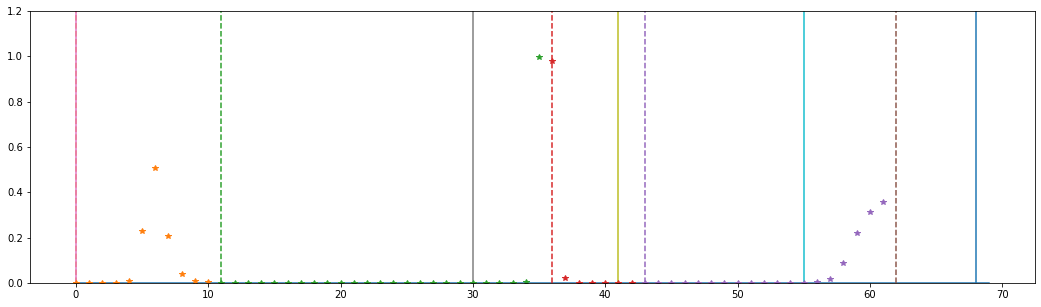

In [31]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(18, 5))

ymax = 1.2

plt.plot([0, item[1][idx].item()], [0, 0])

for pivot in loaded_vidid_selected_frames[cur_vidid]:
    plt.plot([pivot, pivot], [0, ymax], '--')
    
for pivot in video_id_boundary_frames[cur_vidid]:
    plt.plot([pivot, pivot], [0, ymax])
    
all_prob = []
for i, segment in enumerate(prob_each_segment):
#     all_prob.append(segment/torch.sum(segment))
    prob_i = segment / torch.sum(segment)
    prob_i = prob_i.cpu().numpy()
    xs = np.arange(loaded_vidid_selected_frames[cur_vidid][i], loaded_vidid_selected_frames[cur_vidid][i+1])
    plt.plot(xs, prob_i, '*')

plt.ylim([0, ymax])
# all_prob = torch.cat(all_prob).cpu().numpy()
# xs = np.arange(loaded_vidid_selected_frames[cur_vidid][0] + 1, loaded_vidid_selected_frames[cur_vidid][-1])
# plt.plot(xs, all_prob, '-')

In [80]:
cur_vid_feat = torch.softmax(y, dim=1).permute(0,2,1)[idx]
cur_vid_count = item[1][idx]
labels = item[2][idx]

selected_frames = loaded_vidid_selected_frames[cur_vidid]
prob_each_video = prob_video_each_segment_dict[cur_vidid]

log_probs = torch.log(cur_vid_feat + 1e-8)
cumsum_feat = torch.cumsum(log_probs, dim=0)

full_arr = []
for i, cur_ele in enumerate(selected_frames[:-1]):
    next_ele = selected_frames[i + 1]
    label_cur_ele = labels[cur_ele]
    label_next_ele = labels[next_ele]
    prob_list = [] 

    count = 0
    for ele in range(cur_ele, next_ele, 1):
        start_sum = cumsum_feat[cur_ele - 1, :] if cur_ele > 0 else 0
        sum_window_class_1 = (cumsum_feat[ele, :] - start_sum)[label_cur_ele]
        sum_window_class_2 = (cumsum_feat[next_ele - 1, :] - cumsum_feat[ele, :])[label_next_ele]
        prob_list.append((sum_window_class_1 + sum_window_class_2)  * (prob_each_video[i][count].item()))
        count = count + 1
    full_arr.append(torch.stack(prob_list))

In [81]:
-torch.mean(torch.cat(full_arr))

tensor(0.3756, device='cuda:0')

In [83]:
label_cur_ele

tensor(14)

In [84]:
label_next_ele

tensor(47)

In [85]:
selected_frames

[0, 10, 18, 60, 102, 183, 198, 242]

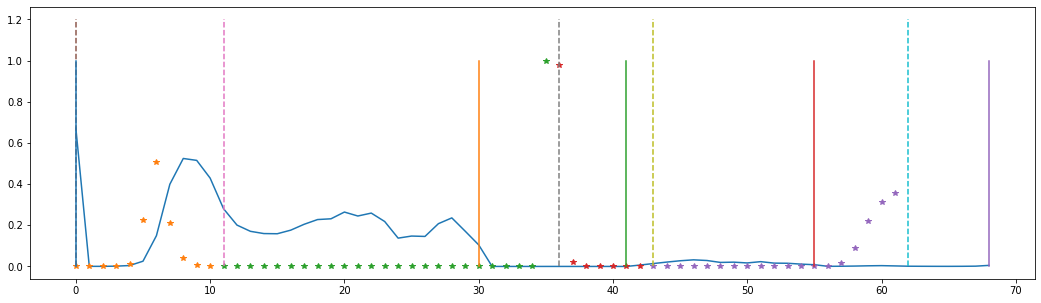

In [32]:
plt_arr = []


for i in range(item[1][idx].item()):
    plt_arr.append(cur_vid_feat[i,item[2][idx][i]].item()) 

fig = plt.figure(figsize=(18, 5))
plt.plot(np.arange(item[1][idx].item()), plt_arr)

all_prob = []
for i, segment in enumerate(prob_each_segment):
#     all_prob.append(segment/torch.sum(segment))
    prob_i = segment / torch.sum(segment)
    prob_i = prob_i.cpu().numpy()
    xs = np.arange(loaded_vidid_selected_frames[cur_vidid][i], loaded_vidid_selected_frames[cur_vidid][i+1])
    plt.plot(xs, prob_i, '*')

for pivot in loaded_vidid_selected_frames[cur_vidid]:
    plt.plot([pivot, pivot], [0, ymax], '--')
    
for pivot in video_id_boundary_frames[cur_vidid]:
    plt.plot([pivot, pivot], [0, 1])